# Домашнее задание  № 5. Матричные разложения/Тематическое моделирование

### Задание № 1 (4 балла)

Попробуйте матричные разложения с 4 классификаторами - SGDClassifier, KNeighborsClassifier, RandomForest, ExtraTreesClassifier (про него подробнее почитайте в документации, он похож на RF). Используйте и NMF и SVD. Сравните результаты на кросс-валидации и выберите лучшее сочетание.

В итоге у вас должно получиться, как минимум 8 моделей (два разложения на каждый классификатор). Используйте 1 и те же параметры кросс-валидации. Параметры векторизации, параметры K в матричных разложениях, параметры классификаторов могут быть разными между экспериментами.

Можете взять поменьше данных, если все будет обучаться слишком долго (не ставьте параметр K слишком большим в NMF, иначе точно будет слишком долго)

In [1]:
import re
import pandas as pd
import numpy as np
from IPython.display import display
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from razdel import tokenize as razdel_tokenize
from pymorphy2 import MorphAnalyzer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import gensim
from matplotlib import pyplot as plt
import seaborn as sns

morph = MorphAnalyzer()

### Решение

Для мультиклассовой классификации возьмем [коллекцию эмоциональных высказываний](https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp) с kaggle.

In [2]:
data = pd.read_csv('emotions.txt', names=['text', 'emotion'], sep=';', encoding='utf-8')
display(data.head(10))

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


Посмотрим, сколько в датасете категорий эмоций и как они распределены.

In [3]:
display(data.value_counts('emotion'))
display(data.value_counts('emotion').apply(lambda x: x/data.shape[0]))
print(data.shape)

emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
dtype: int64

emotion
joy         0.335125
sadness     0.291625
anger       0.134937
fear        0.121063
love        0.081500
surprise    0.035750
dtype: float64

(16000, 2)


Есть две категории -- love и surprise -- которые составляют меньше 10% от всего датасета, поэтому для кросс-валидации лучше будет использовать Stratified K-Fold.

Сохраняем заданные и целевые переменные в X и y.

In [4]:
X = data['text']
y = data['emotion']

Токены в документах уже приведены к нижнему регистру, а также удалена пунктуация. Можно убедиться в этом с помощью регулярных выражений:

In [5]:
print(X.apply(lambda x: re.search(r'[^ a-z0-9]', x)).value_counts())

Series([], Name: text, dtype: int64)


Нормализация, таким образом, будет сведена к лемматизации (с помощью nltk).

In [6]:
X = X.apply(lambda x: nltk.word_tokenize(x))
X = X.apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word) for word in x]))

Чтобы немного облегчить работу с разными пайплайнами, представим пайплайн функцией -- останется только задать нужные алгоритмы матричного разложения и классификатора (векторайзер установим по умолчанию с одинаковыми параметрами).

In [7]:
def apply_pipeline(matrix_decomposition, classifier):
    return(Pipeline([
        ('vct', CountVectorizer(tokenizer=lambda x: x.split(), min_df=2, stop_words='english')),
        ('md', matrix_decomposition),
        ('clf', classifier)
    ]))

Добавим функцию для оценки моделей на кросс-валидации (с семинара).

In [8]:
def evaluate(X, y, pipeline, N=6):
    
    labels = list(set(y))
    metrics = pd.DataFrame(index=labels)
    errors = np.zeros((len(labels), len(labels)))

    kfold = StratifiedKFold(n_splits=N, shuffle=True)
    
    for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
        pipeline.fit(X[train_index], y[train_index])
        preds = pipeline.predict(X[test_index])
        metrics[f'precision_{i}'] = precision_score(y[test_index], preds, labels=labels, average=None)
        metrics[f'recall_{i}'] = recall_score(y[test_index], preds, labels=labels, average=None)
        metrics[f'f1_{i}'] = f1_score(y[test_index], preds, labels=labels, average=None)
        errors += confusion_matrix(y[test_index], preds, labels=labels, normalize='true')
    
    result = pd.DataFrame(index=labels)
    result['precision'] = metrics[[f'precision_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['precision_std'] = metrics[[f'precision_{i}' for i in range(N)]].std(axis=1).round(2)
    result['recall'] = metrics[[f'recall_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['recall_std'] = metrics[[f'recall_{i}' for i in range(N)]].std(axis=1).round(2)
    result['f1'] = metrics[[f'f1_{i}' for i in range(N)]].mean(axis=1).round(2)
    result['f1_std'] = metrics[[f'f1_{i}' for i in range(N)]].std(axis=1).round(2)
    
    result.loc['mean'] = result.mean().round(2)
    errors /= N
    
    return result, errors

Посмотрим, как работают различные алгоритмы на имеющихся данных.

**SGDClassifier**

In [9]:
svd_sgd = apply_pipeline(
    TruncatedSVD(n_components=500), 
    SGDClassifier()
)

In [10]:
metrics_svd_sgd, errors_svd_sgd = evaluate(X, y, svd_sgd)

In [11]:
display(metrics_svd_sgd)

,precision,precision_std,recall,recall_std,f1,f1_std
sadness,0.79,0.03,0.81,0.03,0.80,0.01
love,0.73,0.04,0.65,0.04,0.69,0.04
anger,0.79,0.04,0.69,0.07,0.73,0.04
surprise,0.73,0.04,0.60,0.09,0.65,0.05
joy,0.76,0.02,0.85,0.03,0.80,0.01
fear,0.77,0.03,0.65,0.04,0.71,0.02
mean,0.76,0.03,0.71,0.05,0.73,0.03


In [12]:
nmf_sgd = apply_pipeline(
    NMF(init='nndsvda', n_components=150), 
    SGDClassifier(class_weight='balanced')
)

In [13]:
metrics_nmf_sgd, errors_nmf_sgd = evaluate(X, y, nmf_sgd)

In [14]:
display(metrics_nmf_sgd)

,precision,precision_std,recall,recall_std,f1,f1_std
sadness,0.39,0.09,0.48,0.35,0.34,0.17
love,0.34,0.16,0.26,0.28,0.19,0.09
anger,0.38,0.17,0.15,0.10,0.18,0.06
surprise,0.15,0.09,0.51,0.22,0.21,0.08
joy,0.60,0.09,0.10,0.04,0.16,0.06
fear,0.26,0.13,0.16,0.10,0.16,0.06
mean,0.35,0.12,0.28,0.18,0.21,0.09


SGD работает заметно лучше в связке с SVD (средняя F1-мера по классам равна 0.73), чем с NMF.

**KNeighborsClassifier**

In [15]:
svd_knn = apply_pipeline(
    TruncatedSVD(n_components=700), 
    KNeighborsClassifier(n_neighbors=10)
)

In [16]:
metrics_svd_knn, errors_svd_knn = evaluate(X, y, svd_knn)

In [17]:
display(metrics_svd_knn)

,precision,precision_std,recall,recall_std,f1,f1_std
sadness,0.54,0.02,0.57,0.04,0.56,0.02
love,0.56,0.04,0.20,0.02,0.30,0.02
anger,0.33,0.03,0.45,0.03,0.38,0.02
surprise,0.55,0.07,0.15,0.04,0.24,0.06
joy,0.56,0.02,0.64,0.04,0.60,0.02
fear,0.43,0.04,0.31,0.02,0.36,0.02
mean,0.50,0.04,0.39,0.03,0.41,0.03


In [18]:
nmf_knn = apply_pipeline(
    NMF(init='nndsvda', n_components=150), 
    KNeighborsClassifier(n_neighbors=10)
)

In [19]:
metrics_nmf_knn, errors_nmf_knn = evaluate(X, y, nmf_knn)

In [20]:
display(metrics_nmf_knn)

,precision,precision_std,recall,recall_std,f1,f1_std
sadness,0.37,0.00,0.38,0.02,0.37,0.01
love,0.36,0.08,0.08,0.02,0.13,0.03
anger,0.21,0.02,0.18,0.01,0.19,0.01
surprise,0.26,0.10,0.03,0.02,0.06,0.03
joy,0.40,0.01,0.58,0.02,0.47,0.01
fear,0.23,0.03,0.14,0.02,0.17,0.02
mean,0.30,0.04,0.23,0.02,0.23,0.02


KNN с обоими алгоритмами матричного разложения показывает в среднем худшие результаты, чем SGD+SVD. 

**RandomForestClassifier**

In [21]:
svd_rf = apply_pipeline(
    TruncatedSVD(n_components=500), 
    RandomForestClassifier(n_estimators=150, max_depth=10, class_weight='balanced')
)

In [22]:
metrics_svd_rf, errors_svd_rf = evaluate(X, y, svd_rf)

In [23]:
display(metrics_svd_rf)

,precision,precision_std,recall,recall_std,f1,f1_std
sadness,0.60,0.04,0.73,0.02,0.66,0.02
love,0.66,0.05,0.60,0.05,0.63,0.04
anger,0.80,0.02,0.54,0.03,0.65,0.03
surprise,0.70,0.04,0.63,0.08,0.66,0.06
joy,0.64,0.01,0.69,0.04,0.66,0.02
fear,0.76,0.04,0.51,0.04,0.61,0.04
mean,0.69,0.03,0.62,0.04,0.64,0.03


In [24]:
nmf_rf = apply_pipeline(
    NMF(init='nndsvda', n_components=100), 
    RandomForestClassifier(n_estimators=150, max_depth=10, class_weight='balanced')
)

In [25]:
metrics_nmf_rf, errors_nmf_rf = evaluate(X, y, nmf_rf)

In [26]:
display(metrics_nmf_rf)

,precision,precision_std,recall,recall_std,f1,f1_std
sadness,0.57,0.02,0.44,0.03,0.50,0.02
love,0.35,0.05,0.48,0.05,0.40,0.04
anger,0.44,0.02,0.45,0.03,0.45,0.02
surprise,0.50,0.10,0.49,0.06,0.49,0.07
joy,0.55,0.01,0.60,0.03,0.57,0.01
fear,0.45,0.01,0.45,0.03,0.45,0.01
mean,0.48,0.04,0.49,0.04,0.48,0.03


RandomForest+SVD по некоторым классам уже сравним с SGD+SVD, но по средней F1-мере все-таки уступает (0.64 по сравнению с 0.73). Заметно, что алгоритм NMF с RandomForest уже работает лучше, чем с предыдущими классификаторами.

**ExtraTreesClassifier**

In [27]:
svd_et = apply_pipeline(
    TruncatedSVD(n_components=500), 
    ExtraTreesClassifier(n_estimators=150, max_depth=5, class_weight='balanced')
)

In [28]:
metrics_svd_et, errors_svd_et = evaluate(X, y, svd_et)

In [29]:
display(metrics_svd_et)

,precision,precision_std,recall,recall_std,f1,f1_std
sadness,0.60,0.04,0.60,0.03,0.60,0.02
love,0.36,0.02,0.77,0.04,0.49,0.02
anger,0.55,0.03,0.60,0.04,0.57,0.02
surprise,0.38,0.02,0.84,0.02,0.52,0.02
joy,0.77,0.02,0.43,0.06,0.55,0.05
fear,0.56,0.03,0.55,0.03,0.55,0.01
mean,0.54,0.03,0.63,0.04,0.55,0.02


In [30]:
nmf_et = apply_pipeline(
    NMF(init='nndsvda', n_components=100), 
    ExtraTreesClassifier(n_estimators=150, max_depth=5, class_weight='balanced')
)

In [31]:
metrics_nmf_et, errors_nmf_et = evaluate(X, y, nmf_et)

In [32]:
display(metrics_nmf_et)

,precision,precision_std,recall,recall_std,f1,f1_std
sadness,0.50,0.03,0.12,0.03,0.19,0.04
love,0.18,0.02,0.37,0.04,0.24,0.01
anger,0.28,0.03,0.20,0.04,0.23,0.03
surprise,0.10,0.01,0.25,0.07,0.14,0.02
joy,0.43,0.02,0.43,0.03,0.43,0.02
fear,0.18,0.02,0.34,0.04,0.23,0.02
mean,0.28,0.02,0.28,0.04,0.24,0.02


ExtraTrees+SVD по метрикам показывает среднюю эффективность и все равно не превышает метрики SVD+SGD. C NMF классификатор показывает низкое качество.

Теперь посмотрим на общую таблицу усредненных по всем классам метрик.

In [33]:
models_metrics = [metrics_svd_sgd, metrics_nmf_sgd, \
                  metrics_svd_knn, metrics_nmf_knn, \
                  metrics_svd_rf, metrics_nmf_rf, \
                  metrics_svd_et, metrics_nmf_et]

models_errors = [errors_svd_sgd, errors_nmf_sgd, \
                 errors_svd_knn, errors_nmf_knn, \
                 errors_svd_rf, errors_nmf_rf, \
                 errors_svd_et, errors_nmf_et]

models_names = ['SVD+SGD', 'NMF+SGD', \
                'SVD+KNearest', 'NMF+KNearest', \
                'SVD+RandomForest', 'NMF+RandomForest', \
                'SVD+ExtraTrees', 'NMF+ExtraTrees']

In [35]:
metrics_all = pd.DataFrame()
for m in models_metrics:
    metrics_all = metrics_all.append(m.loc['mean'])
metrics_all.index=pd.Series(models_names)
display(metrics_all)

,precision,precision_std,recall,recall_std,f1,f1_std
SVD+SGD,0.76,0.03,0.71,0.05,0.73,0.03
NMF+SGD,0.35,0.12,0.28,0.18,0.21,0.09
SVD+KNearest,0.50,0.04,0.39,0.03,0.41,0.03
NMF+KNearest,0.30,0.04,0.23,0.02,0.23,0.02
SVD+RandomForest,0.69,0.03,0.62,0.04,0.64,0.03
NMF+RandomForest,0.48,0.04,0.49,0.04,0.48,0.03
SVD+ExtraTrees,0.54,0.03,0.63,0.04,0.55,0.02
NMF+ExtraTrees,0.28,0.02,0.28,0.04,0.24,0.02


Посмотрим также на ошибки моделей.

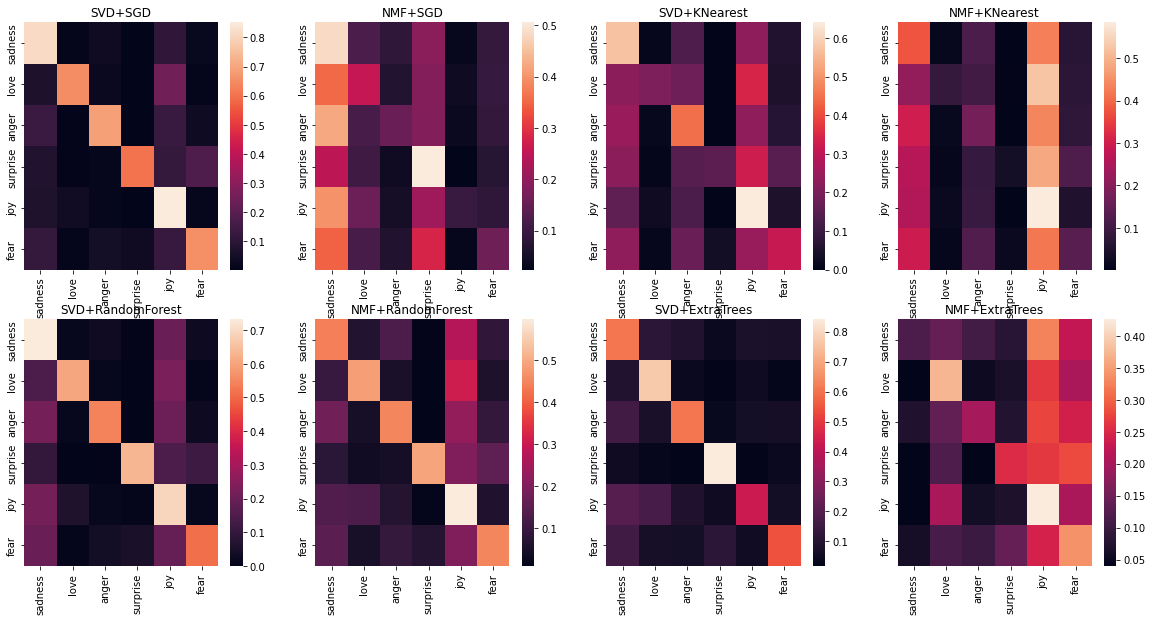

In [36]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
n = 0
for x, y, z in zip(models_metrics, models_errors, models_names):
    sns.heatmap(y, ax=axes[n], xticklabels=x.index.tolist()[:-1], yticklabels=x.index.tolist()[:-1])
    axes[n].set_title(z)
    n += 1

По метрикам и тепловым картам можно сделать вывод, что наиболее эффективной моделью является SVD+SGD. Также неплохие результаты у SVD+RandomForest и SVD+ExtraTrees. Матричное разложение NMF показало лучшие результаты только с классификатором RandomForest.

### Задание № 2 (6 баллов)

В Gensim тоже можно добавить нграммы и tfidf. Постройте 1 модель без них (как в семинаре) и еще 3 модели (1 с нграммами, 1 с tfidf и 1 с нграммами и с tfidf). Сранивте качество с помощью метрик (перплексия, когерентность) и на глаз. Определите лучшую модель. Для каждой модели выберите 1 самую красивую на ваш взгляд тему.

Используйте данные википедии из семинара. Можете взять поменьше данных, если все обучается долго.

Важное требование - получившиеся модели не должны быть совсем плохими. Если хороших тем не получается, попробуйте настроить гиперпараметры, отфильтровать словарь по-другому. 

Нграммы добавляются вот так (перед созданием словаря)

In [37]:
#texts = [text.split() for text in texts]
#ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.4) # threshold можно подбирать
#p = gensim.models.phrases.Phraser(ph)
#ngrammed_texts = p[texts] 

# ! не забудьте, что далее вам нужно будет использовать ngrammed_texts

!! В модели с нграммами вначале посмотрите, что получается после преобразования
Если вы выведите несколько первых текстов в ngrammed_texts, то там должно быть что-то такое:

In [38]:
#[text for text in ngrammed_texts[:3]]
#>> [['новостройка',
#  'нижегородский_область', # нграм
#  'новостро́йка',
#  '—',
#  'сельский',
#  'посёлок',
#  'в',
# 'дивеевский_район', # нграм
#  'нижегородский_область', #нграмм
#  'входить',
#  'в',
#  'состав_сатисский', #нграмм
#  'сельсовет',
#  'посёлок',
#  'расположить',
#  'в',
#  '12,5',
#  'километр',
#....

Если вы не видите нграммов, то попробуйте изменить параметр threshold

Tfidf добавляется вот так (после векторизации и перед обучением lda)

In [39]:
#tfidf = gensim.models.TfidfModel(corpus, id2word=dictionary, )
#corpus = tfidf[corpus]

### Решение

Сохраняем текст (данные Википедии с семинара) и нормализуем его. Функция нормализации возвращает список токенов, так как gensim принимает на вход токенизированные документы.

In [40]:
#добавляем в string.punctuation дополнительные символы, которые тоже часто встречаются в документах
punctuation += '—«»…'

#сохраняем стоп-слова
stop_words = stopwords.words('russian')
stop_words.extend(['это', 'весь', 'который', 'свой', 'стать', 'мочь', 'её', 'иметь', 'также'])

In [41]:
def normalize(text):
    normalized_text = [word.text.strip(punctuation) for word in razdel_tokenize(text)]
    normalized_text = [word.lower() for word in normalized_text if word]
    normalized_text = [morph.parse(word)[0].normal_form for word in normalized_text]
    normalized_text = [word for word in normalized_text if word not in stop_words]
    return normalized_text

In [42]:
#возьмем первые 2000 текстов из корпуса
texts = open('wiki_data.txt', encoding='utf-8').read().splitlines()[:2000]
texts = ([normalize(text) for text in texts])

**1. Модель без нграмм и TF-IDF**

In [43]:
#создаем словарь
dictionary_1 = gensim.corpora.Dictionary(texts)
print(len(dictionary_1))

49540


In [44]:
#фильтруем токены, встречающиеся менее, чем в 5 документах, или более, чем в 50% документах
dictionary_1.filter_extremes(no_below=5, no_above=0.5)
dictionary_1.compactify()
print(len(dictionary_1))

7661


In [45]:
#преобразуем тексты в мешки слов
corpus_1 = [dictionary_1.doc2bow(text) for text in texts]

In [46]:
#обучаем модель
lda_1 = gensim.models.LdaMulticore(
    corpus_1,
    num_topics=15,
    id2word=dictionary_1, 
    passes=10
)

In [47]:
#функция для визуализации топ-частотных слов по темам
def plot_top_words(model, title):
    
    fig, axes = plt.subplots(3, 5, figsize=(30, 15))
    axes = axes.flatten()
    
    for item in model.print_topics(num_topics=15, num_words=10):
        topic_num = item[0]
        top_features = {}
        for feature in item[1].split(' + '):
            word = feature.split('*')[1].strip('"')
            weight = float(feature.split('*')[0])
            top_features[word] = weight
            
        ax = axes[topic_num]
        ax.barh(np.arange(len(top_features)), list(top_features.values()), height=0.6, color='tan')
        ax.set_yticks(np.arange(len(top_features)), labels=list(top_features.keys()))
        ax.set_title(f'Topic {topic_num + 1}',
                    fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(labelsize=17)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=30)
    
    plt.subplots_adjust(hspace=0.4)
    plt.show()

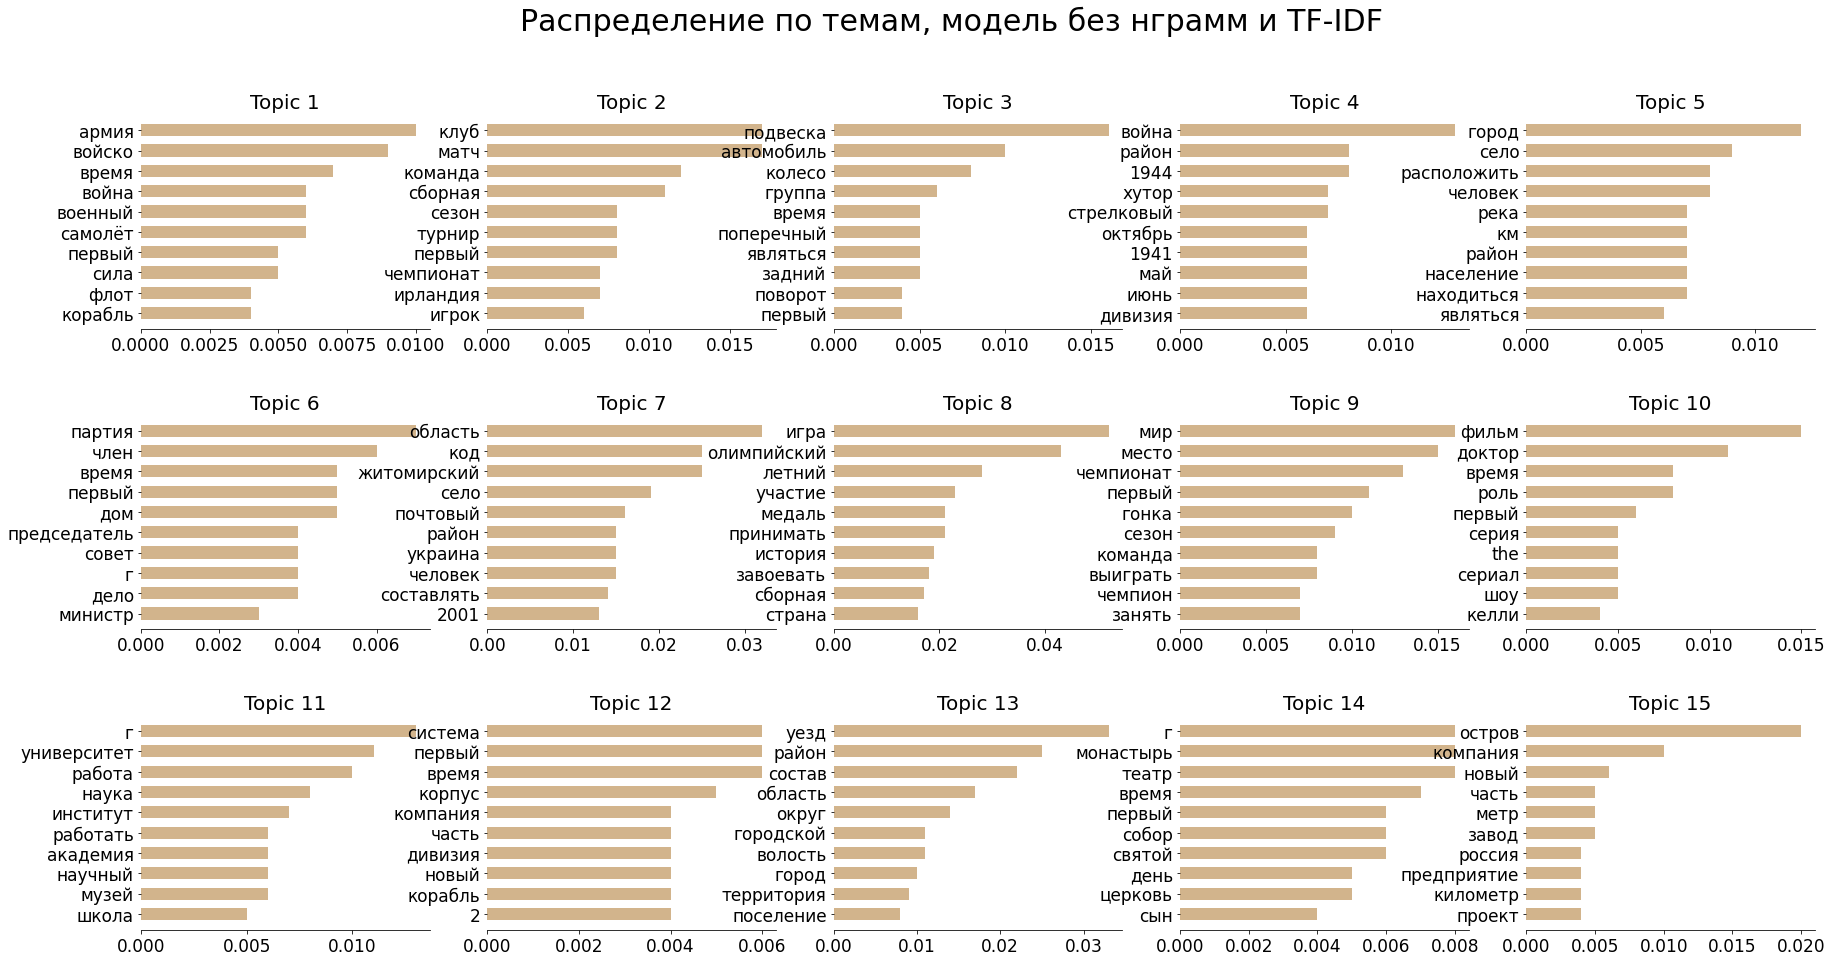

In [48]:
plot_top_words(lda_1, 'Распределение по темам, модель без нграмм и TF-IDF')

Визуально темы выглядят более или менее адекватно: можно выделить topic 1 (военная тематика), topic 2 (спорт), topic 4 (ВОВ), topic 6 (государственная служба), topic 8 (олимпийские игры), topic 11 (образование), topic 13 (территориальное деление). Наиболее удачными можно назвать 8 и 13 темы, в которых все наиболее частотные слова действительно хорошо отражают тематику.

In [49]:
#функция для подсчета перплексии и когерентности
def metrics(model, dictionary, corpus, texts):
    metrics = {}
    
    perplexity = np.exp2(-model.log_perplexity(corpus))
    
    topics = []
    for topic_id, topic in model.show_topics(num_topics=15, formatted=False):
        topic = [word for word, _ in topic]
        topics.append(topic)
        
    coherence_model = gensim.models.CoherenceModel(
        topics=topics, 
        texts=texts, 
        dictionary=dictionary, coherence='c_v'
    )
    
    coherence = coherence_model.get_coherence()
    
    metrics['Perplexity'] = round(perplexity, 5)
    metrics['Coherence'] = round(coherence, 5)  
    
    return metrics

In [50]:
metrics_1 = metrics(lda_1, dictionary_1, corpus_1, texts)
print(metrics_1)

{'Perplexity': 233.9474, 'Coherence': 0.62329}


**2. Модель с нграммами**

In [51]:
#добавляем нграммы
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.4)
p = gensim.models.phrases.Phraser(ph)
ngrammed_texts = p[texts]

display([text for text in ngrammed_texts[:1]])

[['новостройка',
  'нижегородский_область',
  'новостро́йка',
  'сельский',
  'посёлок_дивеевский',
  'район_нижегородский',
  'область',
  'входить_состав',
  'сатисский_сельсовет',
  'посёлок',
  'расположить',
  '12,5',
  'км_юг',
  'село_дивеево',
  '1',
  'км_запад',
  'город',
  'саров',
  'право_берег',
  'река',
  'вичкинза',
  'правый_приток',
  'река',
  'сатис',
  'окружить',
  'смешанный',
  'лес',
  'соединить',
  'асфальтовый',
  'дорога',
  'посёлок',
  'цыгановка',
  '1,5_км',
  'грунтовый',
  'просёлочный',
  'дорога',
  'посёлок_сатис',
  '3,5_км',
  'название',
  'новостройка',
  'являться',
  'сугубо',
  'официальный',
  'местный_население',
  'использовать',
  'исключительно',
  'альтернативный',
  'название',
  'хитрый',
  'употребляться_языковой',
  'оборот',
  'хитрый',
  'ранее',
  'использовать',
  'название',
  'песчаный',
  'известковый',
  'основать',
  '1920-й',
  'год',
  'переселенец',
  'соседний',
  'село_аламасовый',
  'нарышкино',
  'расположить',
  

In [76]:
#создаем словарь
dictionary_2 = gensim.corpora.Dictionary(ngrammed_texts)
print(len(dictionary_2))

52492


In [77]:
#фильтруем токены, встречающиеся менее, чем в 4 документах, или более, чем в 50% документах
dictionary_2.filter_extremes(no_below=4, no_above=0.5)
dictionary_2.compactify()
print(len(dictionary_2))

10740


In [78]:
#преобразуем тексты в мешки слов
corpus_2 = [dictionary_2.doc2bow(text) for text in ngrammed_texts]

In [79]:
#обучаем модель
lda_2 = gensim.models.LdaMulticore(
    corpus_2, 
    num_topics=15,
    id2word=dictionary_2, 
    passes=10)

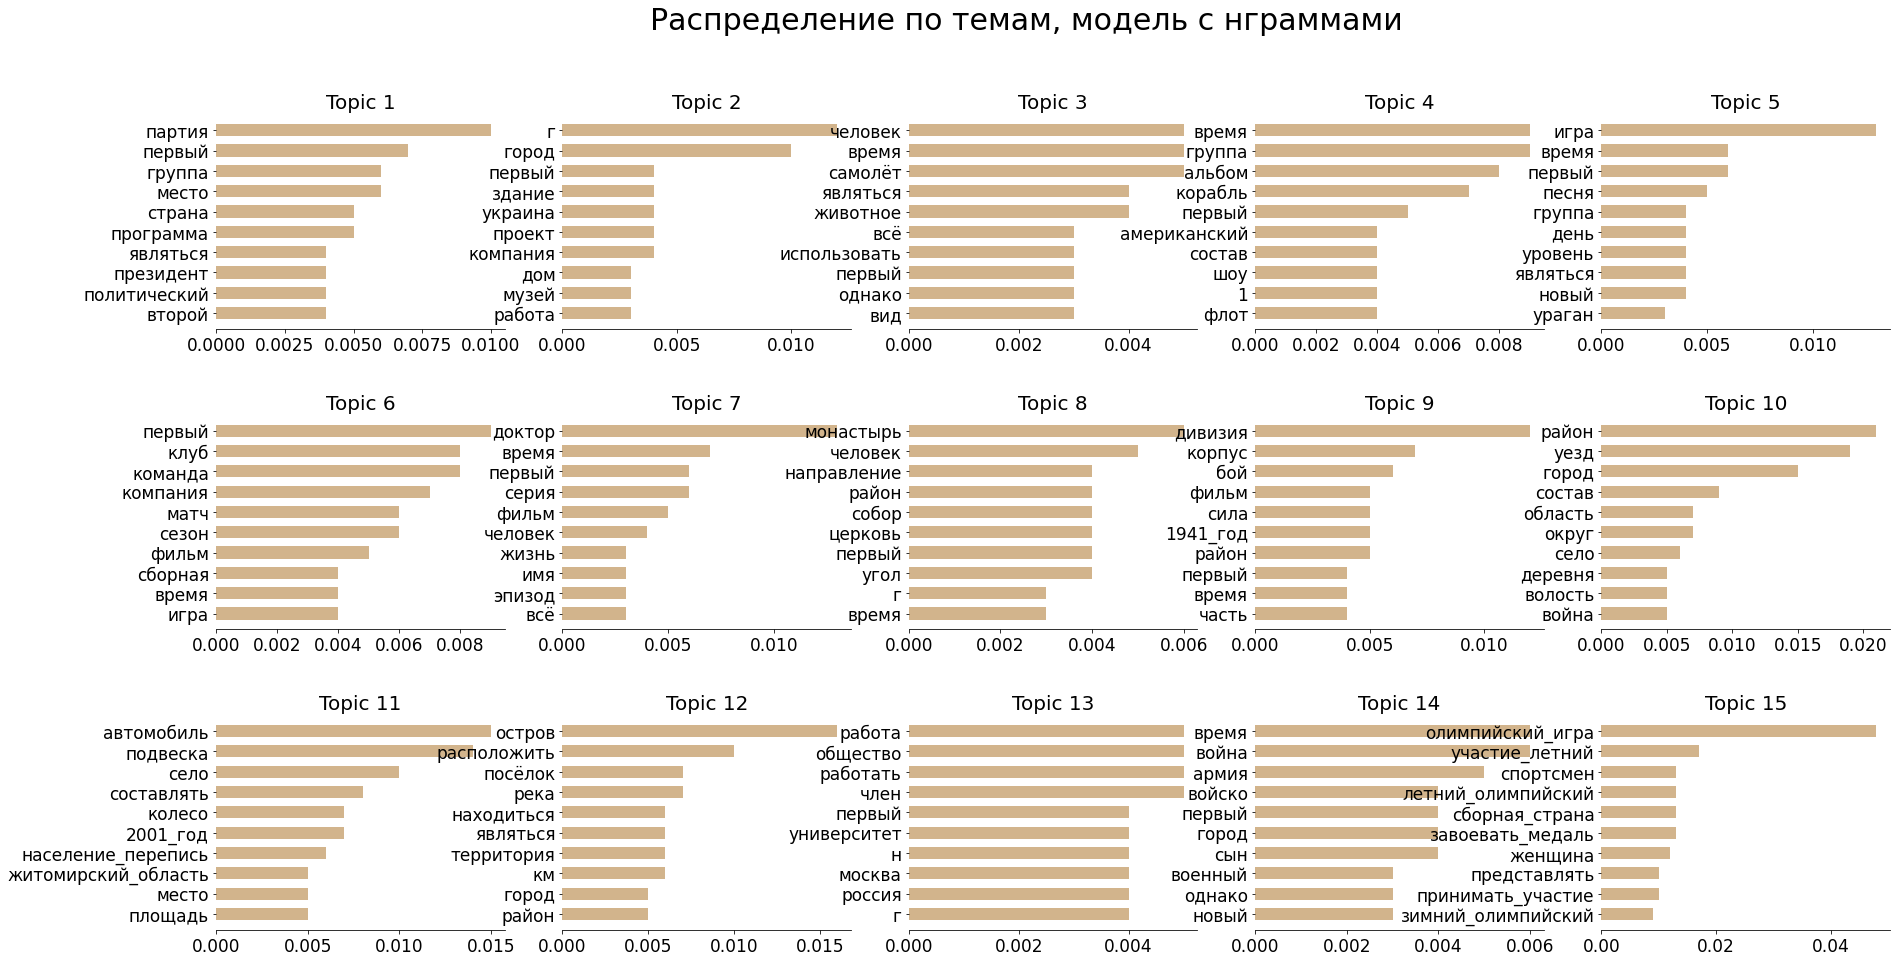

In [80]:
plot_top_words(lda_2, 'Распределение по темам, модель c нграммами')

Кажется, здесь модель менее адекватно смоделировала темы, но можно выделить topic 1 (политика), topic 9 (ВОВ), topic 10 (территориальное деление), topic 14 (военная тематика), topic 15 (олимпийские игры). Наиболее удачной темой является тема 15 (здесь как раз отлично видно нграммы).

In [81]:
metrics_2 = metrics(lda_2, dictionary_2, corpus_2, ngrammed_texts)
print(metrics_2)

{'Perplexity': 339.06514, 'Coherence': 0.46068}


**3. Модель с TF-IDF**

In [58]:
#создаем словарь
dictionary_3 = gensim.corpora.Dictionary(texts)
print(len(dictionary_3))

49540


In [59]:
#фильтруем токены, встречающиеся менее, чем в 5 документах, или более, чем в 50% документах
dictionary_3.filter_extremes(no_below=5, no_above=0.5)
dictionary_3.compactify()
print(len(dictionary_3))

7661


In [60]:
#преобразуем тексты в мешки слов
corpus_3 = [dictionary_3.doc2bow(text) for text in texts]

In [61]:
#добавляем TF-IDF
tfidf = gensim.models.TfidfModel(corpus_3, id2word=dictionary_3)
corpus_3 = tfidf[corpus_3]

In [62]:
#обучаем модель
lda_3 = gensim.models.LdaMulticore(
    corpus_3,
    num_topics=15,
    id2word=dictionary_3, 
    passes=10
)

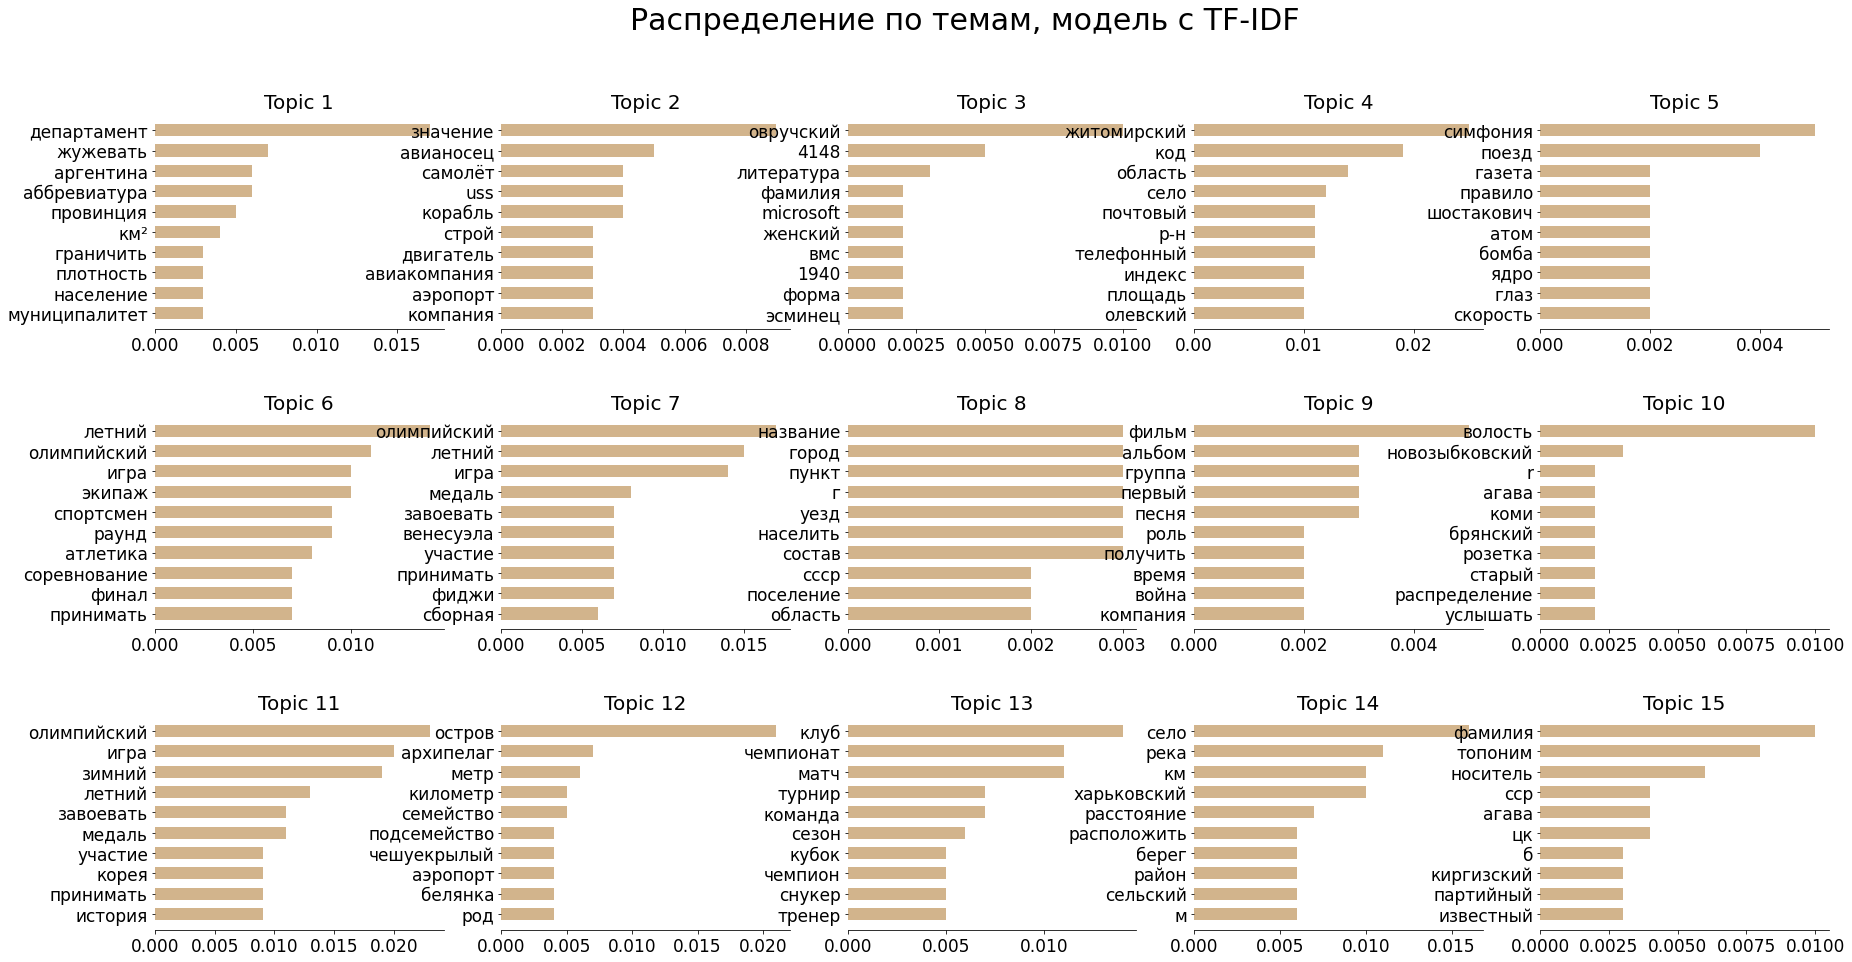

In [63]:
plot_top_words(lda_3, 'Распределение по темам, модель c TF-IDF')

В данном случае тематика спорта почему-то разбилась сразу на несколько групп: topic 6, topic 7, topic 11, 13. Неплохие темы получились также в случае с topic 8 и topic 14 (административные единицы). Наиболее удачной кажутся темы 6 и 13 (спорт).

In [64]:
metrics_3 = metrics(lda_3, dictionary_3, corpus_3, texts)
print(metrics_3)

{'Perplexity': 2960.02836, 'Coherence': 0.56675}


**4. Модель с нграммами и TF-IDF**

In [82]:
#создаем словарь
dictionary_4 = gensim.corpora.Dictionary(ngrammed_texts)
print(len(dictionary_4))

52492


In [83]:
#фильтруем токены, встречающиеся менее, чем в 5 документах, или более, чем в 95% документах
dictionary_4.filter_extremes(no_below=3, no_above=0.5)
dictionary_4.compactify()
print(len(dictionary_4))

13786


In [84]:
#преобразуем тексты в мешки слов
corpus_4 = [dictionary_4.doc2bow(text) for text in ngrammed_texts]

In [85]:
#добавляем TF-IDF
tfidf = gensim.models.TfidfModel(corpus_4, id2word=dictionary_4)
corpus_4 = tfidf[corpus_4]

In [86]:
#обучаем модель
lda_4 = gensim.models.LdaMulticore(
    corpus_4,
    num_topics=15,
    id2word=dictionary_4, 
    passes=10
)

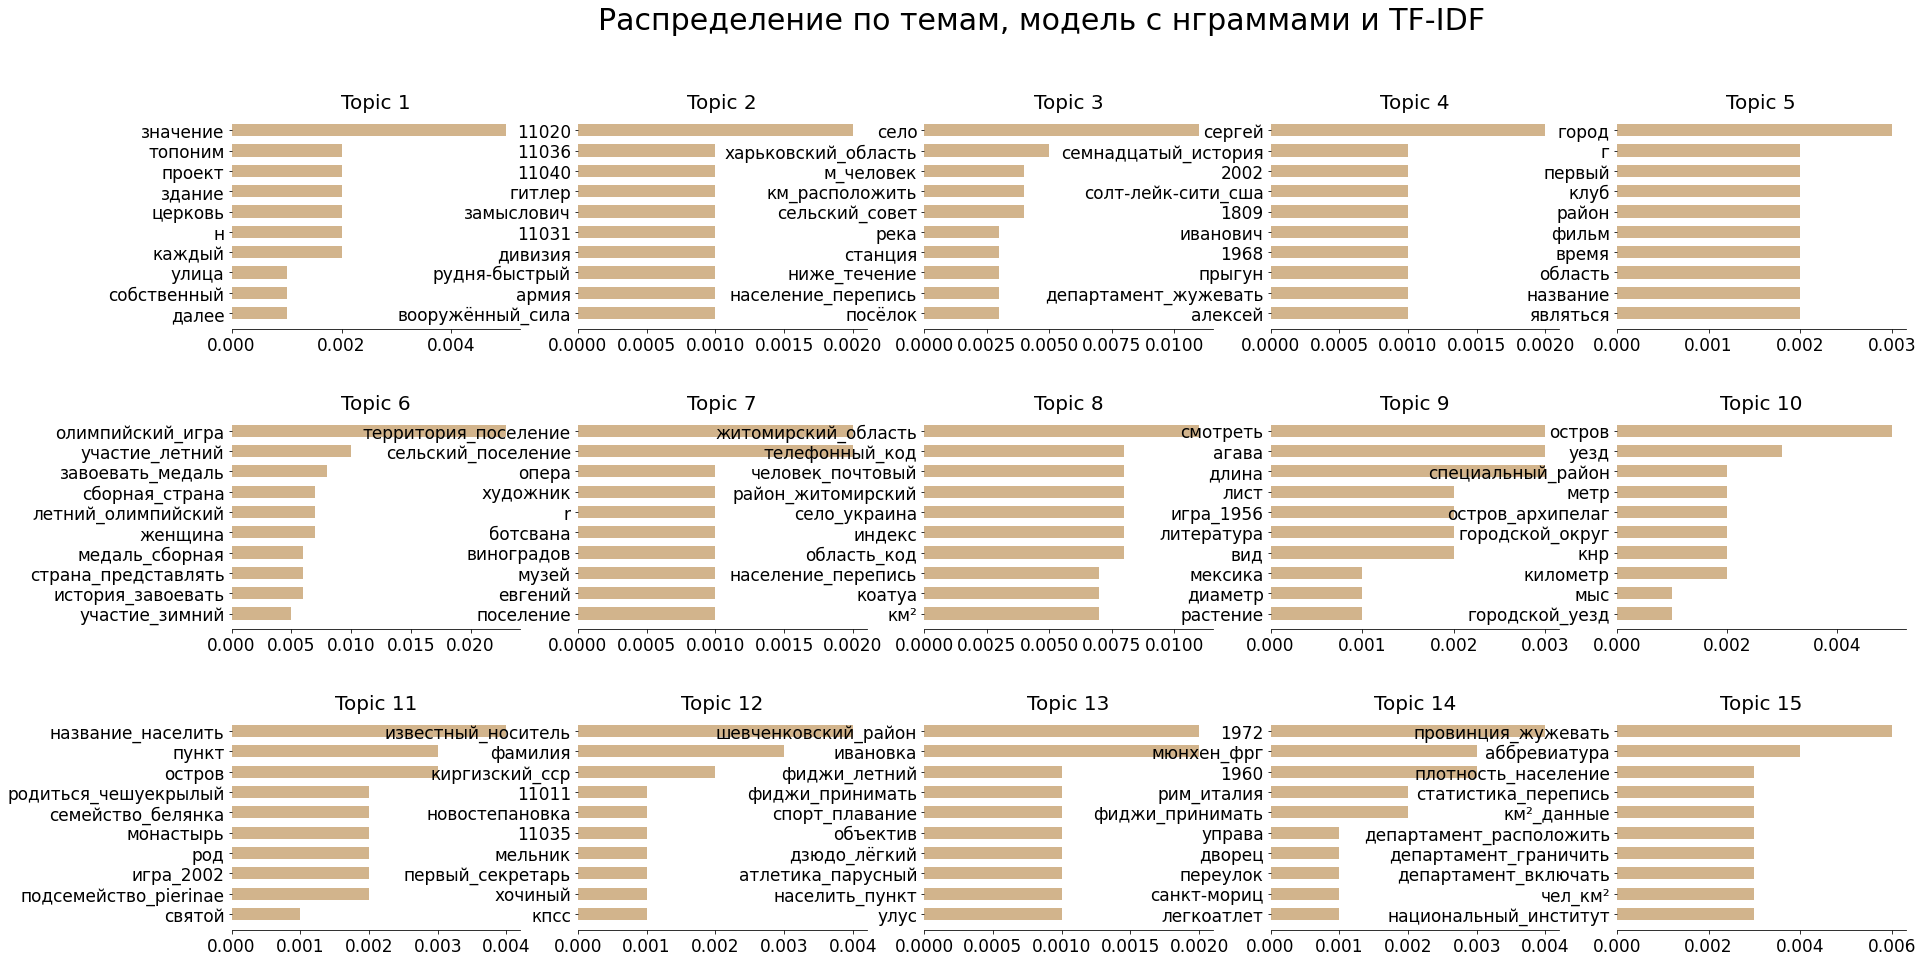

In [87]:
plot_top_words(lda_4, 'Распределение по темам, модель c нграммами и TF-IDF')

Некоторые темы кажутся странными (например, 1 и 4). Удачные темы получились: topic 3 и 15 (статистика, перепись), topic 8 и 10 (административные единицы). Самой "красивой" темой является тема 6 (олимпийские игры).

In [88]:
metrics_4 = metrics(lda_4, dictionary_4, corpus_4, ngrammed_texts)
print(metrics_4)

{'Perplexity': 8997.40566, 'Coherence': 0.45855}


Посмотрим на метрики по всем моделям.

In [89]:
metrics_all = pd.DataFrame([metrics_1, metrics_2, metrics_3, metrics_4])
metrics_all.index=pd.Series(['Без нграмм и TF-IDF', 'С нграммами', 'С TF-IDF', 'С нграммами и TF-IDF'])

In [90]:
display(metrics_all)

,Perplexity,Coherence
Без нграмм и TF-IDF,233.94740,0.62329
С нграммами,339.06514,0.46068
С TF-IDF,2960.02836,0.56675
С нграммами и TF-IDF,8997.40566,0.45855


Как визуально, так и по метрикам лучшей моделью является модель без нграмм и TF-IDF. Не исключено, что если еще поднастроить гиперпараметры, остальные модели могут вполне сравниться с ней (по перплексии модель с нграммами тоже неплоха, по когерентности -- с TF-IDF).